In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Subset
from model import Net
from pytorch_utils import get_features, get_labels
import numpy as np
import copy
import builtins
import statistics

from training import train_model, train_model_CL
import globals
from visualizations import plot_embeddings, plot_confusion_matrix
from feature_attribution import Feature_Importance_Evaluations

In [2]:
ITERATIONS = globals.ITERATIONS
CLASSES_PER_ITER = globals.CLASSES_PER_ITER
SEED = globals.SEED
DEVICE = globals.DEVICE
full_trainset = globals.full_trainset
trainset = globals.trainset
testset = globals.testset
trainloaders = globals.trainloaders
valloaders = globals.valloaders
testloaders = globals.testloaders

In [3]:
# This is the two-step process used to prepare the
# data for use with the convolutional neural network.

# First step is to convert Python Image Library (PIL) format
# to PyTorch tensors.

# Second step is used to normalize the data by specifying a 
# mean and standard deviation for each of the three channels.
# This will convert the data from [0,1] to [-1,1]

# Normalization of data should help speed up conversion and
# reduce the chance of vanishing gradients with certain 
# activation functions.
def initialize_data():
    transform = transforms.Compose([
        transforms.ToTensor()
        #transforms.Normalize((0.5,), (0.5,))  # Normalizes to mean 0.5 and std 0.5 for the single channel
    ])

    globals.full_trainset = torchvision.datasets.MNIST('/files/', train=True, download=True,
                                transform=transform)
    targets = np.array(globals.full_trainset.targets)

    # Perform stratified split
    train_indices, val_indices = train_test_split(
        np.arange(len(targets)),
        test_size=0.15,
        stratify=targets
    )

    # Create subsets
    valset = Subset(globals.full_trainset, val_indices)
    globals.trainset = Subset(globals.full_trainset, train_indices)

    globals.testset = torchvision.datasets.MNIST('/files/', train=False, download=True,
                                transform=transform)

    # Define class pairs for each subset
    class_pairs = [tuple(range(i*CLASSES_PER_ITER,(i+1)*CLASSES_PER_ITER)) for i in range(ITERATIONS)]
    #print(class_pairs)

    # Dictionary to hold data loaders for each subset
    globals.trainloaders = []
    globals.testloaders = []
    globals.valloaders = []
    subset_indices = []
    # Loop over each class pair
    for i, t in enumerate(class_pairs):
        # Get indices of images belonging to the specified class pair
        subs_ind = [idx for idx, (_, label) in enumerate(globals.trainset) if label in list(t)]
        val_subset_indices = [idx for idx, (_, label) in enumerate(valset) if label in list(t)]
        test_subset_indices = [idx for idx, (_, label) in enumerate(globals.testset) if label in list(t)]
        # Create a subset for the current class pair
        train_subset = Subset(globals.trainset, subs_ind)
        globals.trainloaders.append(DataLoader(train_subset, batch_size=globals.BATCH_SIZE, shuffle=True, pin_memory=True, num_workers = 0))

        subset_indices.append(subs_ind)
        
        val_subset = Subset(valset, val_subset_indices)
        globals.valloaders.append(DataLoader(val_subset, batch_size=500, shuffle=False))

        test_subset = Subset(globals.testset, test_subset_indices)
        globals.testloaders.append(DataLoader(test_subset, batch_size=500, shuffle=False))


In [4]:
from sklearn import metrics
import matplotlib.pyplot as plt

def run_experiment(verbose = False):
    def _print(*args, **kwargs):
        if verbose:
            print(*args, **kwargs)
    initialize_data()
    prevModel = None
    globals.OOD_CLASS=1
    globals.BATCH_SIZE=4

    #[Denis] added code:
    Feature_Importance_Eval=Feature_Importance_Evaluations(globals.valloaders,DEVICE)

    for i in range(ITERATIONS):
        model = Net((i+1)*(CLASSES_PER_ITER+globals.OOD_CLASS), withDropout=True)
        if prevModel is not None:
            with torch.no_grad():
                model.copyPrev(prevModel)
        train_loader = globals.trainloaders[i]
        val_loader = globals.valloaders[i]
        if prevModel:
            _print("CL TRAIN!!")
            train_model_CL(
                model,
                prevModel,
                train_loader,
                val_loader,
                i,
                verbose,
                10000,
                True,
                freeze_nonzero_params=False,
                l1_loss=0,
                ewc_loss=0,
                kd_loss=1,
                distance_loss=0,
                center_loss=0,
                param_reuse_loss=0,
                stopOnLoss=None,
                stopOnValAcc=0.92,
                )
        else:
            train_model(
                model, 
                train_loader, 
                val_loader, 
                verbose, 
                epochs=10000, 
                l1_loss=0,
                stopOnLoss=0.05,
                center_loss =0,
                )

        #[Denis] added code:
        Feature_Importance_Eval.Task_Feature_Attribution(model,i)
        
        if verbose or i == ITERATIONS-1:
            _print("ITERATION", i+1)
            _print("ACCURACIES PER TASK:")
            accumPred = []
            all_labels = []
            with torch.no_grad():
                for j in range(i+1):
                    val_loader = globals.testloaders[j]
                    val_labels = get_labels(val_loader).to(DEVICE)
                    all_labels.append(val_labels)
                    model.eval()
                    pred = model(get_features(val_loader).to(DEVICE))
                    model.train()
                    accumPred.append(pred)
                    sliced_pred = pred[:, j*(CLASSES_PER_ITER+globals.OOD_CLASS):(j+1)*(CLASSES_PER_ITER+globals.OOD_CLASS)]
                    _, predicted = torch.max(sliced_pred, 1)  # Get the class predictions
                    predicted += j*CLASSES_PER_ITER
                    correct = (predicted == val_labels).sum().item()  # Count how many were correct
                    accuracy = correct / val_labels.size(0)  # Accuracy as a percentage
                    _print(str(accuracy), end=' ')
            accumPred = torch.cat(accumPred)
            all_labels = torch.cat(all_labels)
            predicted = []
            for x in accumPred:
                if globals.OOD_CLASS == 1:
                    x_pred = x[[i for i in range(x.size(0)) if (i + 1) % (CLASSES_PER_ITER+1) != 0]]
                else:
                    x_pred = x
                x_pred = torch.softmax(x_pred, dim=-1)
                max = 0
                for (k, v) in enumerate(x_pred):
                    if v > max:
                        max = v
                        p = k
                predicted.append(p)
            predicted = torch.tensor(predicted).to(DEVICE)
            correct = (predicted == all_labels).sum().item()  # Count how many were correct
            accuracy = correct / all_labels.size(0)  # Accuracy as a percentage
            _print("Accuracy on tasks so far:", accuracy)
            if verbose:
                plot_confusion_matrix(predicted.cpu(), all_labels.cpu(), list(range(CLASSES_PER_ITER*(i+1))))
        prevModel = copy.deepcopy(model)
        
    #[Denis] added code:
    avg_shap_vals,shap_vals=Feature_Importance_Eval. Get_Feature_Change_Score(prevModel)
    _print("Average SHAPC values (ordered as tasks):", shap_vals)
    _print("Averaged SHAPC value:", avg_shap_vals)
    
    return accuracy

In [5]:
def run_experiments(n_runs=1, verbose=True):
    def _print(*args, **kwargs):
        if verbose:
            print(*args, **kwargs)
    accuracies = []
    for r in range(n_runs):
        print(f"Starting run {r+1}.")
        acc = run_experiment(verbose)
        accuracies.append(acc)
        _print(f"Run {r} finished with accuracy {acc}")
    mean_acc = statistics.mean(accuracies)
    acc_std = statistics.stdev(accuracies)
    print("Accuracies:")
    print(accuracies)
    print(f"Mean accuracy across {n_runs} runs: {mean_acc}")
    print(f"Standard deviation of accuracy across {n_runs} runs: {acc_std}")

In [6]:
run_experiments(n_runs=4, verbose=False)

Starting run 1.
Starting run 2.
Starting run 3.
Starting run 4.
Accuracies:
[0.8167, 0.8793, 0.8503, 0.7635]
Mean accuracy across 4 runs: 0.82745
Standard deviation of accuracy across 4 runs: 0.049718239443219764


Epoch 0, CE Loss: 0.1639, center loss: 0.0000
Validation loss 0.01293731713667512
Fraction of nonzero parameters 0.9999732299414182 

Epoch 1, CE Loss: 0.0522, center loss: 0.0000
Validation loss 0.018148188246414065
Fraction of nonzero parameters 0.9999598449121273 

Epoch 2, CE Loss: 0.0380, center loss: 0.0000
Validation loss 0.024539552628993988
Fraction of nonzero parameters 0.9999687682649879 

ITERATION 1
ACCURACIES PER TASK:
0.9957446808510638 Accuracy on tasks so far: 0.9990543735224586


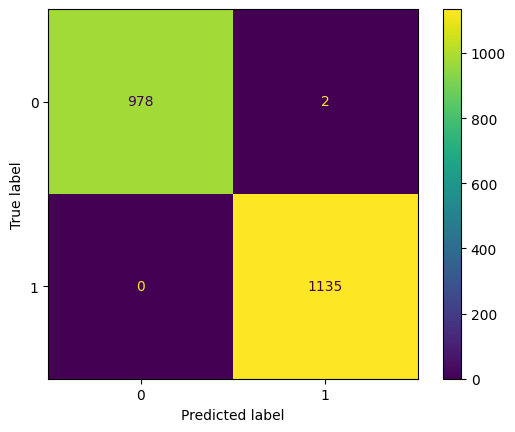

CL TRAIN!!
Epoch 0  CELoss: 0.1378, KLLoss: 0.0101, L1Loss: 0.0000, EWCLoss: 0.0000, CenterLoss: 0.0000, InterCenterLoss: 0.0000, ParamReuseLoss: 0.0000
Validation losses: 0.04801798053085804 0.011413577012717724
Validation accuracy (for last task) 0.9691289966923925
Fraction of nonzero parameters 0.9999554601412804
Total validation accuracy 0.9698357123619714


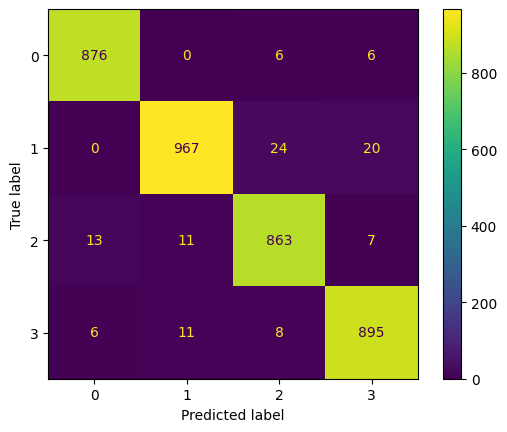

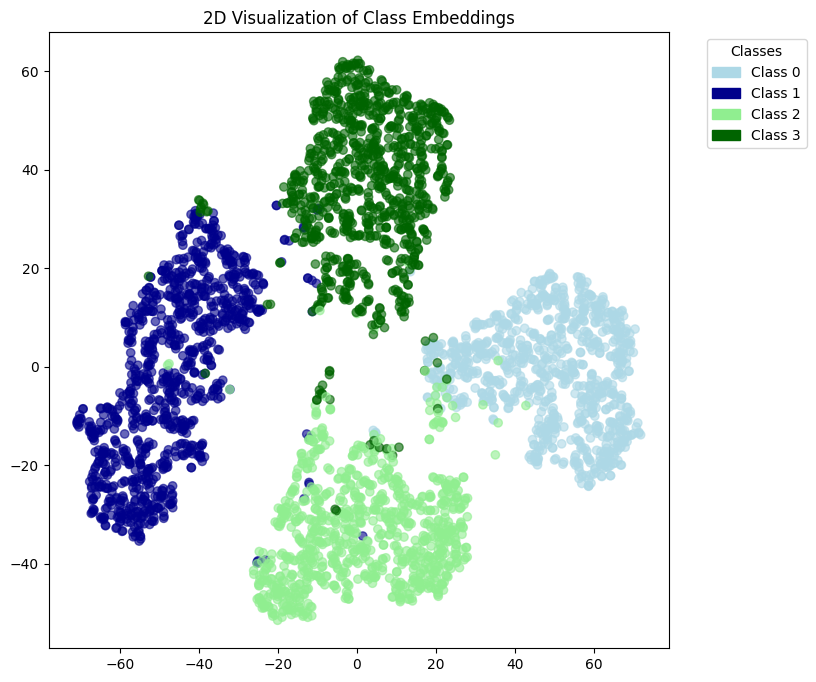

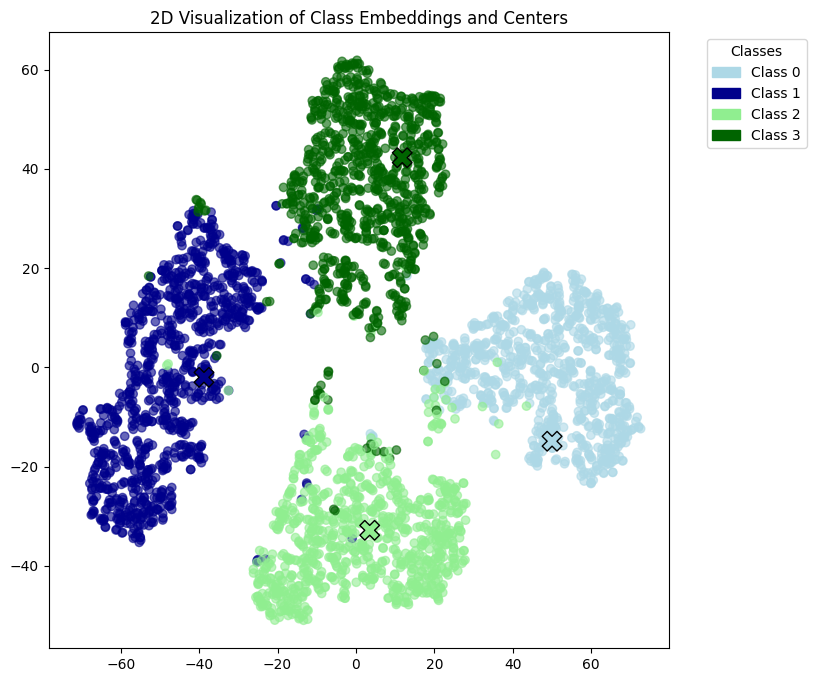

ITERATION 2
ACCURACIES PER TASK:
0.9962174940898345 0.9911851126346719 Accuracy on tasks so far: 0.9778686552802501


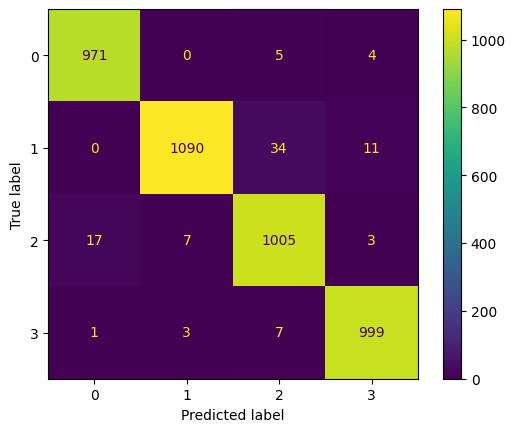

CL TRAIN!!
Epoch 0  CELoss: 0.0861, KLLoss: 0.0095, L1Loss: 0.0000, EWCLoss: 0.0000, CenterLoss: 0.0000, InterCenterLoss: 0.0000, ParamReuseLoss: 0.0000
Validation losses: 0.01387094403617084 0.013765702256932855
Validation accuracy (for last task) 0.9644760213143873
Fraction of nonzero parameters 0.9999733220693181
Total validation accuracy 0.8905960755275824


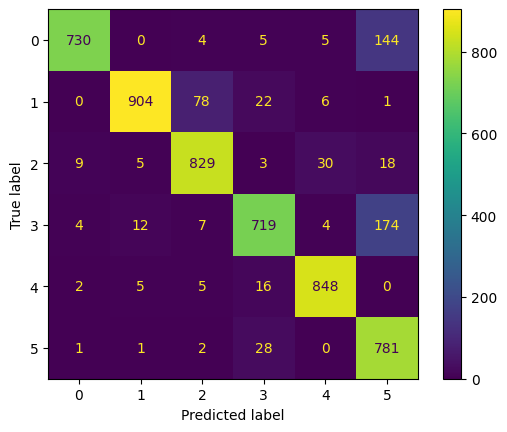

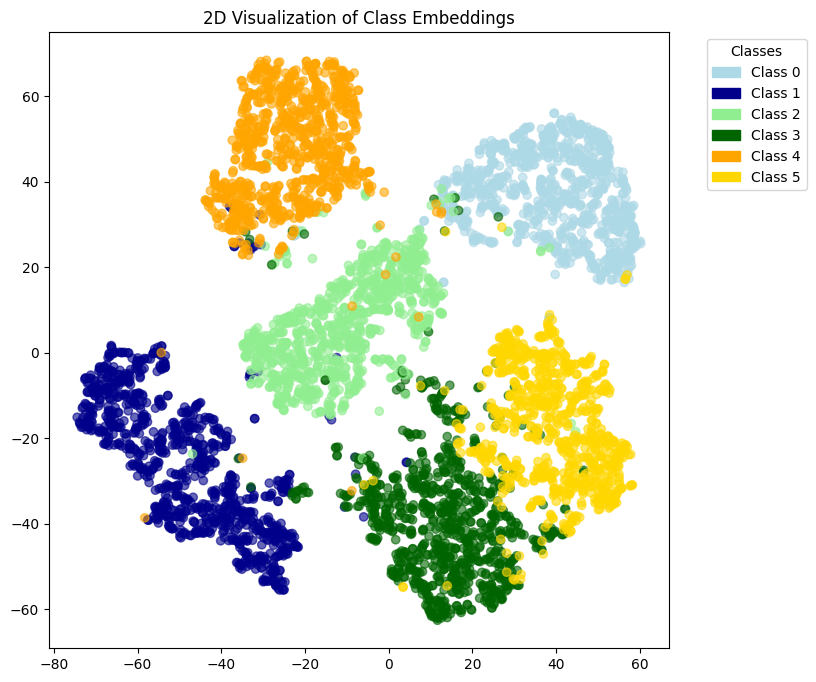

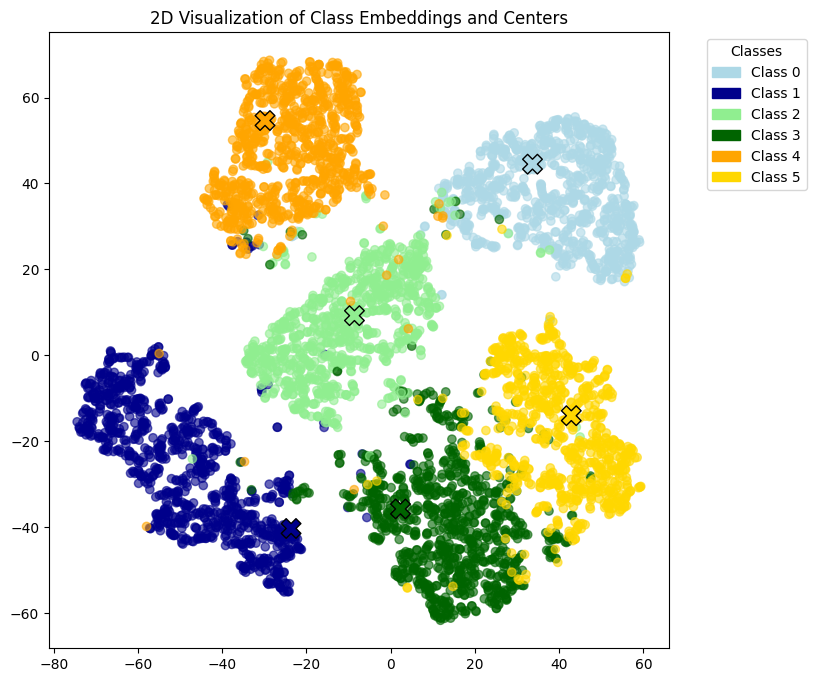

ITERATION 3
ACCURACIES PER TASK:
0.992434988179669 0.9872673849167483 0.9989327641408752 Accuracy on tasks so far: 0.9039960205604377


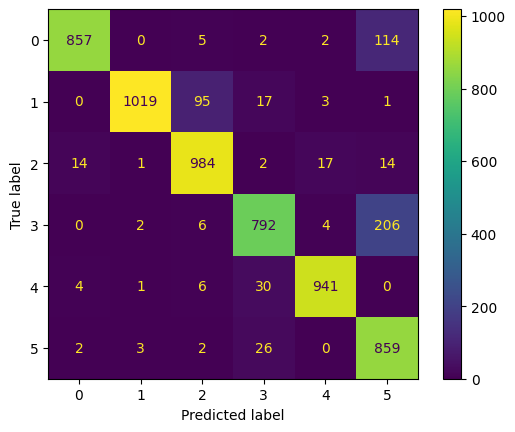

CL TRAIN!!
Epoch 0  CELoss: 0.0596, KLLoss: 0.0092, L1Loss: 0.0000, EWCLoss: 0.0000, CenterLoss: 0.0000, InterCenterLoss: 0.0000, ParamReuseLoss: 0.0000
Validation losses: 0.006567612872458994 0.024850777233950794
Validation accuracy (for last task) 0.9748358862144421
Fraction of nonzero parameters 0.9999334197397156
Total validation accuracy 0.8742738589211618


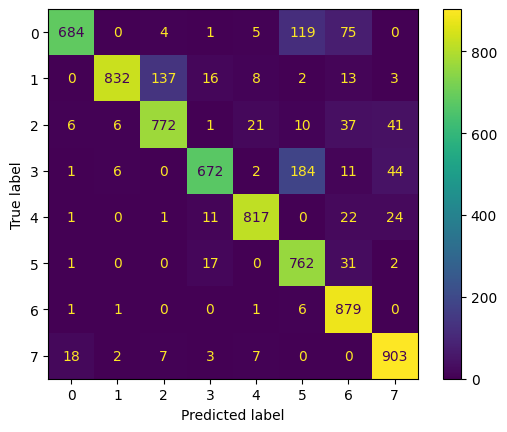

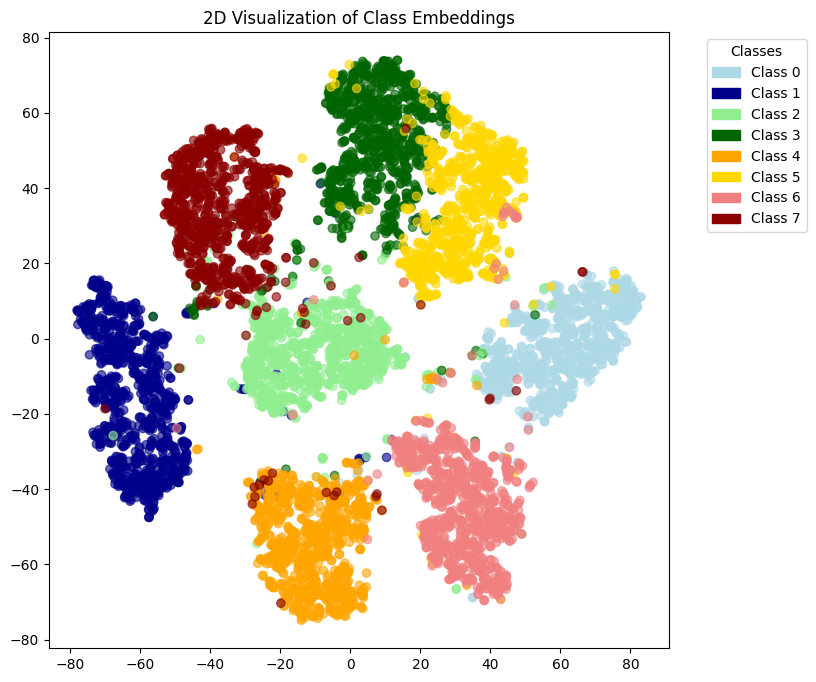

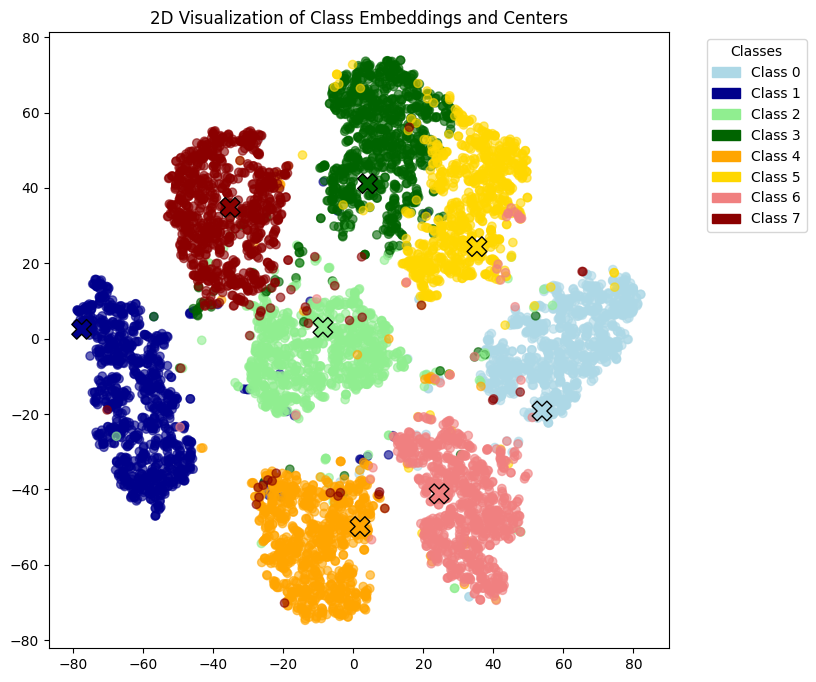

ITERATION 4
ACCURACIES PER TASK:
0.9891252955082742 0.9862879529872673 0.9978655282817502 0.9974823766364552 Accuracy on tasks so far: 0.8812523387800923


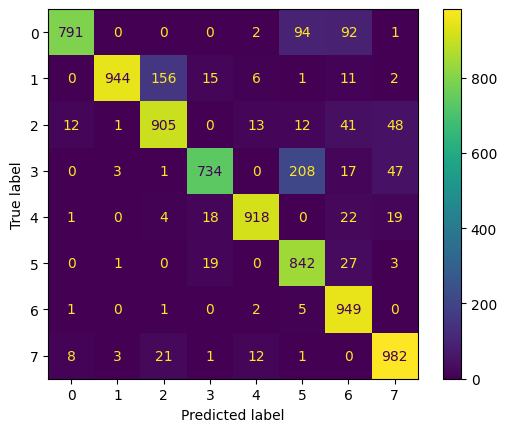

CL TRAIN!!
Epoch 0  CELoss: 0.1104, KLLoss: 0.0119, L1Loss: 0.0000, EWCLoss: 0.0000, CenterLoss: 0.0000, InterCenterLoss: 0.0000, ParamReuseLoss: 0.0000
Validation losses: 0.0529569867067039 0.01375893922522664
Validation accuracy (for last task) 0.8344632768361582
Fraction of nonzero parameters 0.9999645514203803
Total validation accuracy 0.8313333333333334


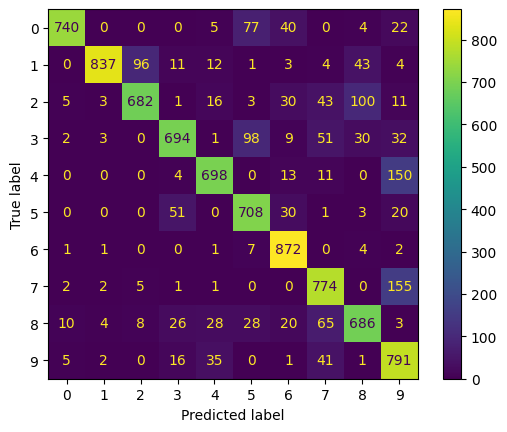

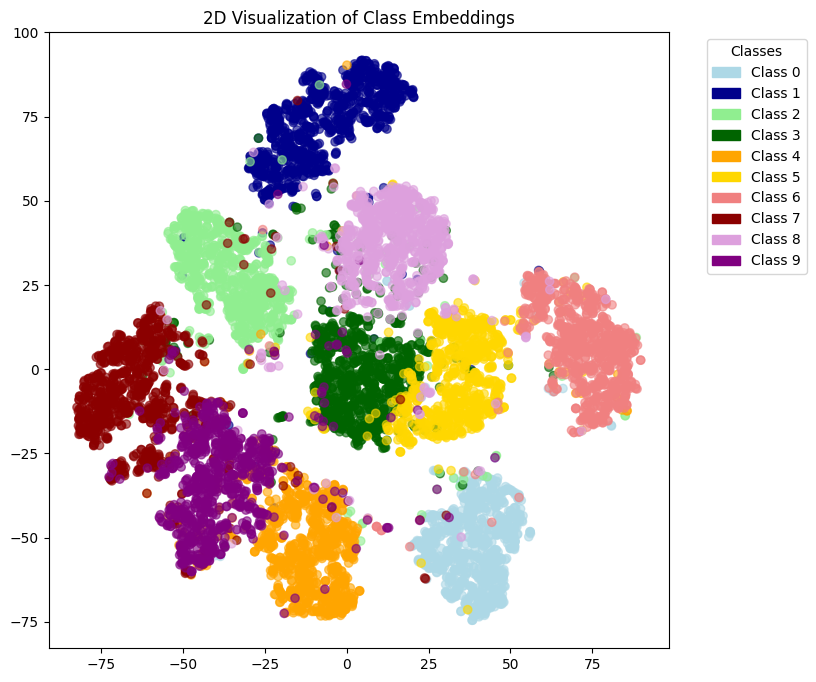



Epoch 1  CELoss: 0.0588, KLLoss: 0.0108, L1Loss: 0.0000, EWCLoss: 0.0000, CenterLoss: 0.0000, InterCenterLoss: 0.0000, ParamReuseLoss: 0.0000
Validation losses: 0.033812017645686865 0.01083127548918128
Validation accuracy (for last task) 0.8887005649717514
Fraction of nonzero parameters 0.9999689824928327
Total validation accuracy 0.8262222222222222


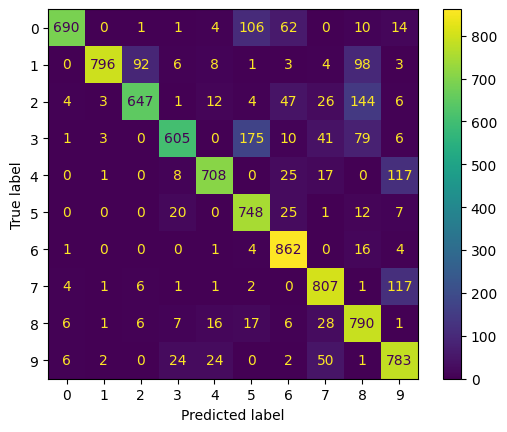

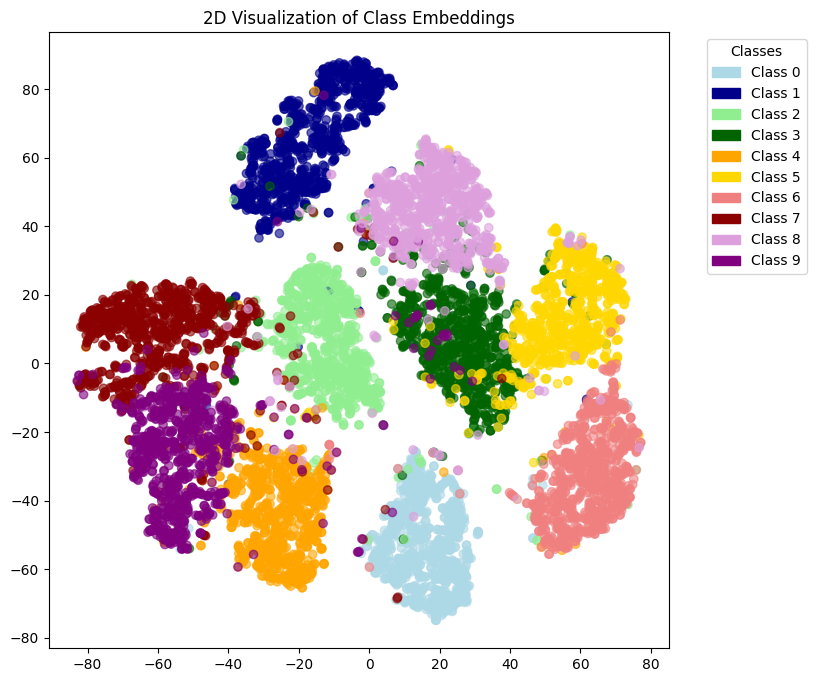



Epoch 2  CELoss: 0.0499, KLLoss: 0.0096, L1Loss: 0.0000, EWCLoss: 0.0000, CenterLoss: 0.0000, InterCenterLoss: 0.0000, ParamReuseLoss: 0.0000
Validation losses: 0.05129517009481788 0.01881267921999097
Validation accuracy (for last task) 0.8943502824858757
Fraction of nonzero parameters 0.9999556892754753
Total validation accuracy 0.8128888888888889


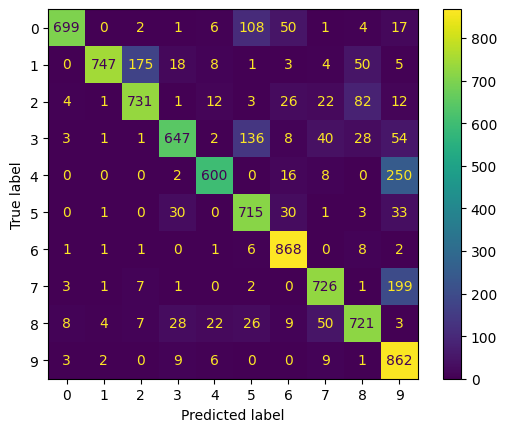

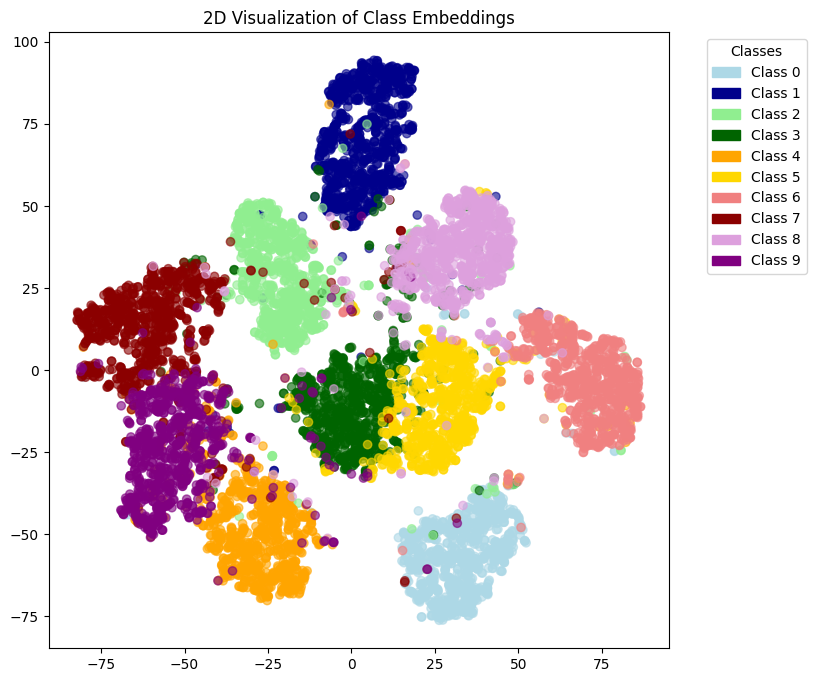



Epoch 3  CELoss: 0.0363, KLLoss: 0.0087, L1Loss: 0.0000, EWCLoss: 0.0000, CenterLoss: 0.0000, InterCenterLoss: 0.0000, ParamReuseLoss: 0.0000
Validation losses: 0.034420501440763474 0.01153040723875165
Validation accuracy (for last task) 0.9367231638418079
Fraction of nonzero parameters 0.9999468271305704
Total validation accuracy 0.8288888888888889


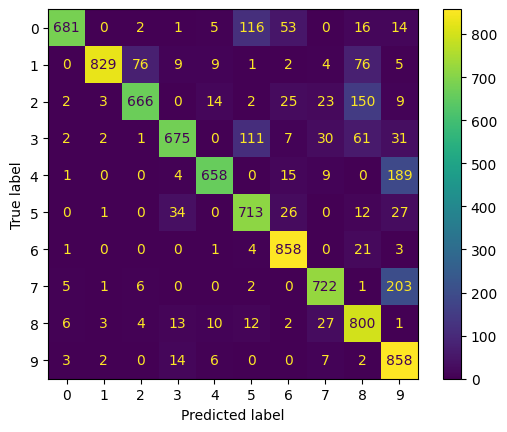

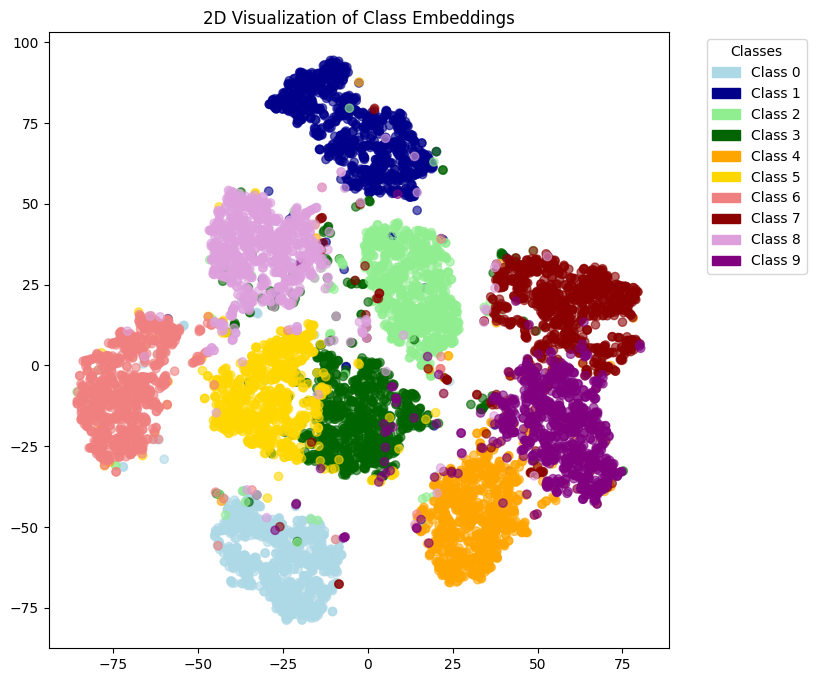

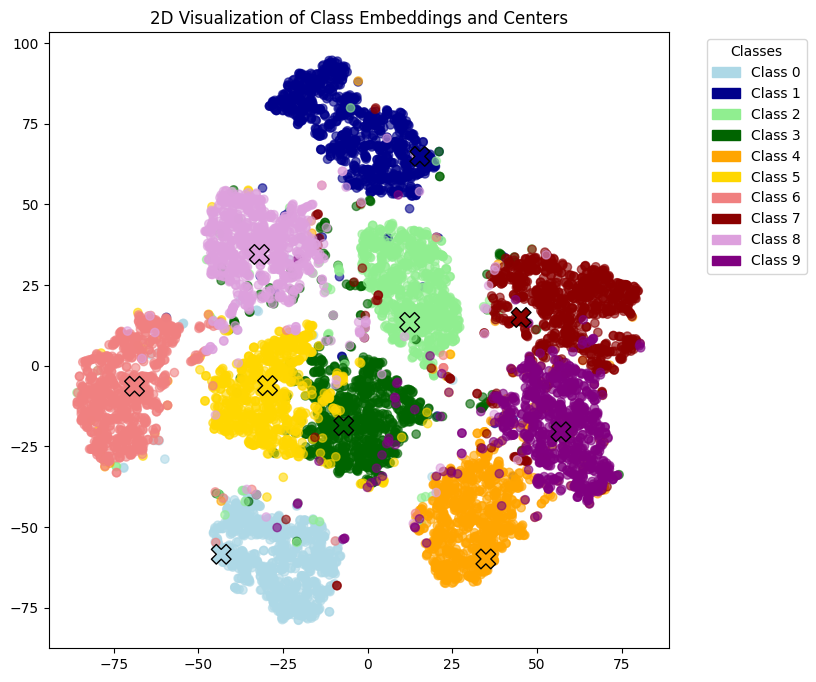

ITERATION 5
ACCURACIES PER TASK:
0.9881796690307328 0.9823702252693438 0.9973319103521878 0.9964753272910373 0.9929399899142713 Accuracy on tasks so far: 0.8284


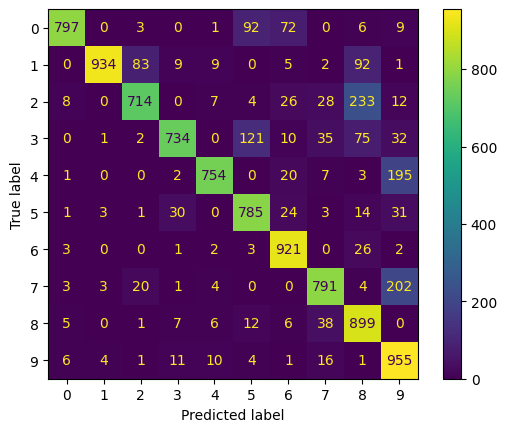

0.8284

In [7]:
run_experiment(verbose=True)